# Transfer Learning part 3: Scaling up

In [ ]:
!nvidia-smi

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-12-27 17:52:13--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-12-27 17:52:13 (62.6 MB/s) - ‘helper_functions.py’ saved [10246/10246]



In [ ]:
from helper_functions import * # Import series of helper functions for our notebook

In [ ]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip #download food101 dataset

--2023-12-27 17:52:28--  https://storage.googleapis.com/ztm_tf_course/food_vision/101_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.159.207, 142.251.120.207, 142.251.161.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.159.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1625420029 (1.5G) [application/zip]
Saving to: ‘101_food_classes_10_percent.zip’

101_food_classes_10 100%[===================>]   1.51G   147MB/s    in 14s     

2023-12-27 17:52:42 (114 MB/s) - ‘101_food_classes_10_percent.zip’ saved [1625420029/1625420029]



In [ ]:
#unzip dataset
import zipfile
unzip_data("/content/101_food_classes_10_percent.zip")

In [ ]:
# How many images/classes are there?
walk_through_dir("/content/101_food_classes_10_percent")

In [ ]:
#setup train and test directories
train_dir="/content/101_food_classes_10_percent/train/"
test_dir="/content/101_food_classes_10_percent/test/"

In [ ]:
import tensorflow as tf

# Setup data inputs
IMG_SIZE=(224, 224)

train_data_all=tf.keras.preprocessing.image_dataset_from_directory(train_dir, label_mode="categorical", image_size=IMG_SIZE, batch_size=32)
test_data=tf.keras.preprocessing.image_dataset_from_directory(test_dir, label_mode="categorical", image_size=IMG_SIZE, batch_size=32, shuffle=False)


Found 7575 files belonging to 101 classes.
Found 25250 files belonging to 101 classes.


In [ ]:
# Create checkpoint callback

checkpoint_path="101_classes_10_percent_ckpt"
checkpoint_callback=tf.keras.callbacks.ModelCheckpoint(checkpoint_path, save_weights_only=True, save_best_only=True, save_freq="epoch", monitor="val_accuracy")

In [ ]:
# Create data augmentation layer to incorporate it right into the model
data_augmentaion=tf.keras.models.Sequential(name="data_augmentation")
data_augmentaion.add(tf.keras.layers.RandomFlip("horizontal"))
data_augmentaion.add(tf.keras.layers.RandomHeight(0.2))
data_augmentaion.add(tf.keras.layers.RandomWidth(0.2))
data_augmentaion.add(tf.keras.layers.RandomRotation(0.2))
data_augmentaion.add(tf.keras.layers.RandomZoom(0.2))


In [ ]:
# Setup the base model and freeze its layers (this will extract features)
base_model=tf.keras.applications.efficientnet.EfficientNetB0(include_top=False)
base_model.trainable=False

# Setup model architecture with trainable top layers
inputs=tf.keras.layers.Input(shape=(224, 224, 3), name="input_layer")

x=data_augmentaion(inputs)
x=base_model(x, training=False)
x=tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling")(x)

outputs=tf.keras.layers.Dense(101, activation="softmax", name="Output_layer")(x)

model_0=tf.keras.Model(inputs, outputs)

# Compile
model_0.compile(loss="categorical_crossentropy", optimizer="adam", metrics="accuracy")


16705208/16705208 [==============================] - 0s 0us/step


In [ ]:
model_0.summary() # Get a summary of the model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 data_augmentation (Sequent  (None, None, None, 3)     0         
 ial)                                                            
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling (Gl  (None, 1280)              0         
 obalAveragePooling2D)                                           
                                                                 
 Output_layer (Dense)        (None, 101)               129381    
                                                             

In [ ]:
# Fit
History_0=model_0.fit(train_data_all, epochs=5, validation_data=test_data, validation_steps=int(0.15*len(test_data)), callbacks=[create_tensorboard_callback("Transfer_learning", "Model_0_10_percent"), checkpoint_callback])

Saving TensorBoard log files to: Transfer_learning/Model_0_10_percent/20231226-200320
Epoch 1/5
237/237 [==============================] - 154s 606ms/step - loss: 3.3827 - accuracy: 0.2734 - val_loss: 2.4593 - val_accuracy: 0.4640
Epoch 2/5
237/237 [==============================] - 105s 440ms/step - loss: 2.2282 - accuracy: 0.4878 - val_loss: 2.0357 - val_accuracy: 0.4995
Epoch 3/5
237/237 [==============================] - 90s 378ms/step - loss: 1.8565 - accuracy: 0.5620 - val_loss: 1.8457 - val_accuracy: 0.5283
Epoch 4/5
237/237 [==============================] - 84s 351ms/step - loss: 1.6301 - accuracy: 0.5996 - val_loss: 1.7871 - val_accuracy: 0.5281
Epoch 5/5
237/237 [==============================] - 79s 332ms/step - loss: 1.4770 - accuracy: 0.6341 - val_loss: 1.7271 - val_accuracy: 0.5416


In [ ]:
# Evaluate on the whole test dataset
Feature_extraction_results=model_0.evaluate(test_data)
Feature_extraction_results

790/790 [==============================] - 56s 71ms/step - loss: 1.5961 - accuracy: 0.5768


[1.5961073637008667, 0.5767524838447571]

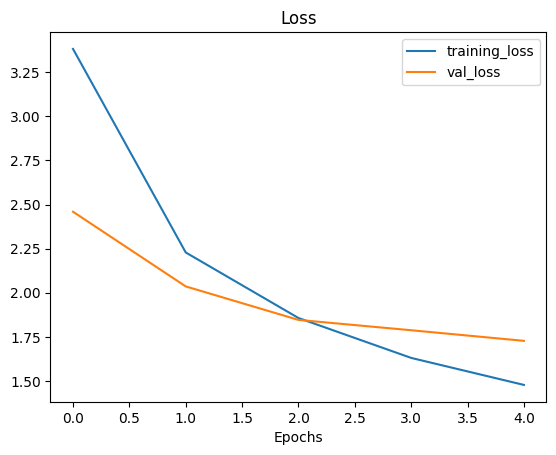

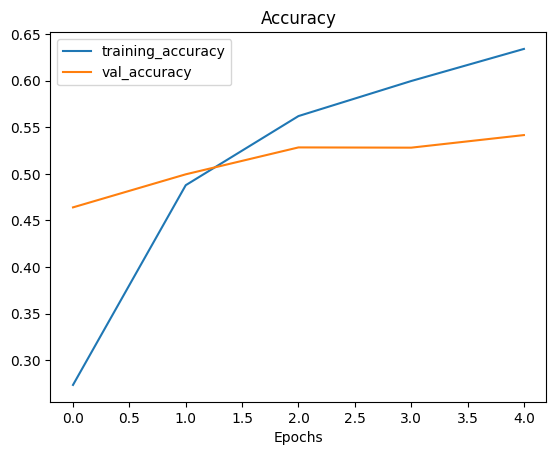

In [ ]:
plot_loss_curves(History_0)

In [ ]:
# Unfreeze all of the layers in the base model
base_model.trainable=True

# Refreeze every layer except the last 5
for layer in base_model.layers[:-5]:
  layer.trainable=False

for i, layer in enumerate(model_0.layers[2].layers):
  print(i, layer.name, layer.trainable)

0 input_1 False
1 rescaling False
2 normalization False
3 rescaling_1 False
4 stem_conv_pad False
5 stem_conv False
6 stem_bn False
7 stem_activation False
8 block1a_dwconv False
9 block1a_bn False
10 block1a_activation False
11 block1a_se_squeeze False
12 block1a_se_reshape False
13 block1a_se_reduce False
14 block1a_se_expand False
15 block1a_se_excite False
16 block1a_project_conv False
17 block1a_project_bn False
18 block2a_expand_conv False
19 block2a_expand_bn False
20 block2a_expand_activation False
21 block2a_dwconv_pad False
22 block2a_dwconv False
23 block2a_bn False
24 block2a_activation False
25 block2a_se_squeeze False
26 block2a_se_reshape False
27 block2a_se_reduce False
28 block2a_se_expand False
29 block2a_se_excite False
30 block2a_project_conv False
31 block2a_project_bn False
32 block2b_expand_conv False
33 block2b_expand_bn False
34 block2b_expand_activation False
35 block2b_dwconv False
36 block2b_bn False
37 block2b_activation False
38 block2b_se_squeeze False
39

In [ ]:
# Recompile model with lower learning (it's typically best practice to lower the learning rate when fine-tuning)
model_0.compile(loss="categorical_crossentropy", optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), metrics="accuracy")

In [ ]:
#load best model weights
model_0.load_weights(checkpoint_path)

In [ ]:
# Fine-tune our model
History_fine_tuned=model_0.fit(train_data_all, epochs=10, validation_data=test_data, validation_steps=int(0.15*len(test_data)), initial_epoch=History_0.epoch[-1], callbacks=[create_tensorboard_callback("transfer_learning", "Fine_tuned_model_0")])

Saving TensorBoard log files to: transfer_learning/Fine_tuned_model_0/20231226-201539
Epoch 5/10
237/237 [==============================] - 80s 299ms/step - loss: 2.2784 - accuracy: 0.4356 - val_loss: 2.1522 - val_accuracy: 0.4672
Epoch 6/10
237/237 [==============================] - 69s 288ms/step - loss: 1.3319 - accuracy: 0.6383 - val_loss: 1.9078 - val_accuracy: 0.5278
Epoch 7/10
237/237 [==============================] - 62s 260ms/step - loss: 0.9350 - accuracy: 0.7360 - val_loss: 2.1893 - val_accuracy: 0.4868
Epoch 8/10
237/237 [==============================] - 60s 250ms/step - loss: 0.6892 - accuracy: 0.8015 - val_loss: 2.1324 - val_accuracy: 0.5000
Epoch 9/10
237/237 [==============================] - 55s 231ms/step - loss: 0.5308 - accuracy: 0.8422 - val_loss: 2.2330 - val_accuracy: 0.4968
Epoch 10/10
237/237 [==============================] - 54s 228ms/step - loss: 0.4268 - accuracy: 0.8713 - val_loss: 2.0052 - val_accuracy: 0.5516


In [ ]:
model_0.evaluate(test_data) # Evaluate on the whole test dataset

790/790 [==============================] - 54s 69ms/step - loss: 1.9853 - accuracy: 0.5601


[1.9852790832519531, 0.5601187944412231]

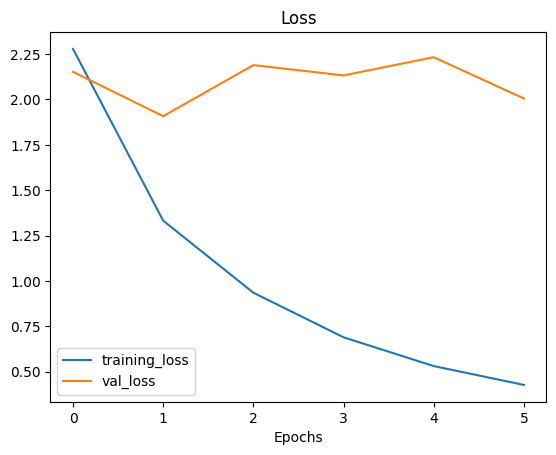

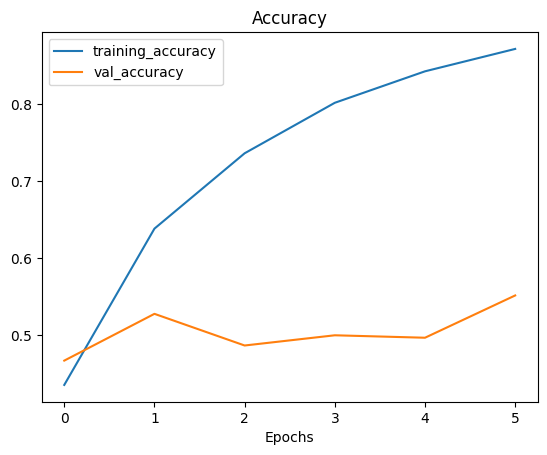

In [ ]:
plot_loss_curves(History_fine_tuned)

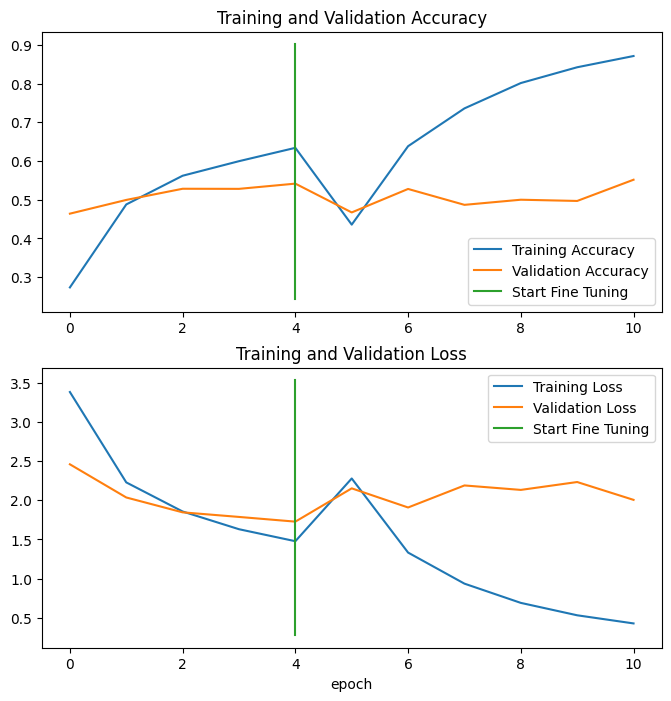

In [ ]:
compare_historys(History_0, History_fine_tuned) # Compare the histories of feature extraction model with fine-tuning model

##saving and loading th model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#model_0.save("/content/drive/MyDrive/Model_0_101_classes_10percent")

In [ ]:
loaded_model=tf.keras.models.load_model("/content/drive/MyDrive/Model_0_101_classes_10percent") # Load and evaluate saved model

In [ ]:
loaded_model.evaluate(test_data)

790/790 [==============================] - 62s 77ms/step - loss: 1.9142 - accuracy: 0.5670


[1.9142276048660278, 0.567049503326416]

## Evaluating the performance of the model across all classes

In [ ]:
import tensorflow as tf
# Download pretrained model
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip


--2023-12-27 17:53:21--  https://storage.googleapis.com/ztm_tf_course/food_vision/06_101_food_class_10_percent_saved_big_dog_model.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.112.207, 74.125.124.207, 172.217.212.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.112.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 46760742 (45M) [application/zip]
Saving to: ‘06_101_food_class_10_percent_saved_big_dog_model.zip’

06_101_food_class_1 100%[===================>]  44.59M   177MB/s    in 0.3s    

2023-12-27 17:53:21 (177 MB/s) - ‘06_101_food_class_10_percent_saved_big_dog_model.zip’ saved [46760742/46760742]



In [ ]:
unzip_data("/content/06_101_food_class_10_percent_saved_big_dog_model.zip")

In [ ]:
model=tf.keras.models.load_model("/content/06_101_food_class_10_percent_saved_big_dog_model") # Load in saved model

In [ ]:
res_down_model=model.evaluate(test_data) # Evaluate loaded model

790/790 [==============================] - 68s 80ms/step - loss: 1.8027 - accuracy: 0.6078


## Making predictions with the trained model

In [ ]:
pred_probs=model.predict(test_data, verbose=1) # Make predictions with model

790/790 [==============================] - 72s 84ms/step


In [ ]:
len(pred_probs) #number of preds

25250

In [ ]:
pred_probs.shape #prediction shape

(25250, 101)

In [ ]:
pred_classes=pred_probs.argmax(axis=1)
pred_classes

array([ 52,   0,   0, ..., 100,  94, 100])

In [ ]:
# To get our test labels we need to unravel our test_data BatchDataset
y_labels=[]

for images, labels in test_data.unbatch():
  y_labels.append(labels.numpy().argmax())

y_labels[:10]

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
# compare ground truth to predictions

from sklearn.metrics import accuracy_score

sklearn_accuracy=accuracy_score(y_true=y_labels, y_pred=pred_classes)

In [ ]:
sklearn_accuracy

0.6077623762376237

### make a confusion matrix

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
# make some changes to our make_confusion_matrix function to ensure the x-labels print vertically

def make_confusion_matrix(y_true, y_pred, classes=None, figsize=(10, 10), text_size=15, norm=False, savefig=False):
  """Makes a labelled confusion matrix comparing predictions and ground truth labels.

  If classes is passed, confusion matrix will be labelled, if not, integer class values
  will be used.

  Args:
    y_true: Array of truth labels (must be same shape as y_pred).
    y_pred: Array of predicted labels (must be same shape as y_true).
    classes: Array of class labels (e.g. string form). If `None`, integer labels are used.
    figsize: Size of output figure (default=(10, 10)).
    text_size: Size of output figure text (default=15).
    norm: normalize values or not (default=False).
    savefig: save confusion matrix to file (default=False).

  Returns:
    A labelled confusion matrix plot comparing y_true and y_pred.

  Example usage:
    make_confusion_matrix(y_true=test_labels, # ground truth test labels
                          y_pred=y_preds, # predicted labels
                          classes=class_names, # array of class label names
                          figsize=(15, 15),
                          text_size=10)
  """
  # Create the confustion matrix
  cm = confusion_matrix(y_true, y_pred)
  cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
  n_classes = cm.shape[0] # find the number of classes we're dealing with

  # Plot the figure and make it pretty
  fig, ax = plt.subplots(figsize=figsize)
  cax = ax.matshow(cm, cmap=plt.cm.Blues) # colors will represent how 'correct' a class is, darker == better
  fig.colorbar(cax)

  # Are there a list of classes?
  if classes:
    labels = classes
  else:
    labels = np.arange(cm.shape[0])

  # Label the axes
  ax.set(title="Confusion Matrix",
         xlabel="Predicted label",
         ylabel="True label",
         xticks=np.arange(n_classes), # create enough axis slots for each class
         yticks=np.arange(n_classes),
         xticklabels=labels, # axes will labeled with class names (if they exist) or ints
         yticklabels=labels)

  # Make x-axis labels appear on bottom
  ax.xaxis.set_label_position("bottom")
  ax.xaxis.tick_bottom()

  plt.xticks(rotation=70, fontsize=text_size)
  plt.yticks(fontsize=text_size)

  # Set the threshold for different colors
  threshold = (cm.max() + cm.min()) / 2.

  # Plot the text on each cell
  for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    if norm:
      plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)
    else:
      plt.text(j, i, f"{cm[i, j]}",
              horizontalalignment="center",
              color="white" if cm[i, j] > threshold else "black",
              size=text_size)

  # Save the figure to the current working directory
  if savefig:
    fig.savefig("confusion_matrix.png")

In [ ]:
make_confusion_matrix(y_labels, pred_classes, classes=train_data_all.class_names, figsize=(100, 100), text_size=20)

### SkLearn classification Report

In [ ]:
#evaluate using sklearn classification_report
from sklearn.metrics import classification_report

print(classification_report(y_labels, pred_classes))

              precision    recall  f1-score   support

           0       0.29      0.20      0.24       250
           1       0.51      0.69      0.59       250
           2       0.56      0.65      0.60       250
           3       0.74      0.53      0.62       250
           4       0.73      0.43      0.54       250
           5       0.34      0.54      0.42       250
           6       0.67      0.79      0.72       250
           7       0.82      0.76      0.79       250
           8       0.40      0.37      0.39       250
           9       0.62      0.44      0.51       250
          10       0.62      0.42      0.50       250
          11       0.84      0.49      0.62       250
          12       0.52      0.74      0.61       250
          13       0.56      0.60      0.58       250
          14       0.56      0.59      0.57       250
          15       0.44      0.32      0.37       250
          16       0.45      0.75      0.57       250
          17       0.37    

In [ ]:
# Get a dictionary of the classification report
classification_report_dict=classification_report(y_labels, pred_classes, output_dict=True)
classification_report_dict

{'0': {'precision': 0.29310344827586204,
  'recall': 0.204,
  'f1-score': 0.24056603773584903,
  'support': 250},
 '1': {'precision': 0.5088235294117647,
  'recall': 0.692,
  'f1-score': 0.5864406779661017,
  'support': 250},
 '2': {'precision': 0.5625,
  'recall': 0.648,
  'f1-score': 0.6022304832713754,
  'support': 250},
 '3': {'precision': 0.7415730337078652,
  'recall': 0.528,
  'f1-score': 0.616822429906542,
  'support': 250},
 '4': {'precision': 0.7346938775510204,
  'recall': 0.432,
  'f1-score': 0.544080604534005,
  'support': 250},
 '5': {'precision': 0.34177215189873417,
  'recall': 0.54,
  'f1-score': 0.41860465116279066,
  'support': 250},
 '6': {'precision': 0.6677966101694915,
  'recall': 0.788,
  'f1-score': 0.7229357798165138,
  'support': 250},
 '7': {'precision': 0.8197424892703863,
  'recall': 0.764,
  'f1-score': 0.7908902691511386,
  'support': 250},
 '8': {'precision': 0.4025974025974026,
  'recall': 0.372,
  'f1-score': 0.3866943866943867,
  'support': 250},
 '9

In [ ]:
class_names=train_data_all.class_names

In [ ]:
class_names

['apple_pie',
 'baby_back_ribs',
 'baklava',
 'beef_carpaccio',
 'beef_tartare',
 'beet_salad',
 'beignets',
 'bibimbap',
 'bread_pudding',
 'breakfast_burrito',
 'bruschetta',
 'caesar_salad',
 'cannoli',
 'caprese_salad',
 'carrot_cake',
 'ceviche',
 'cheese_plate',
 'cheesecake',
 'chicken_curry',
 'chicken_quesadilla',
 'chicken_wings',
 'chocolate_cake',
 'chocolate_mousse',
 'churros',
 'clam_chowder',
 'club_sandwich',
 'crab_cakes',
 'creme_brulee',
 'croque_madame',
 'cup_cakes',
 'deviled_eggs',
 'donuts',
 'dumplings',
 'edamame',
 'eggs_benedict',
 'escargots',
 'falafel',
 'filet_mignon',
 'fish_and_chips',
 'foie_gras',
 'french_fries',
 'french_onion_soup',
 'french_toast',
 'fried_calamari',
 'fried_rice',
 'frozen_yogurt',
 'garlic_bread',
 'gnocchi',
 'greek_salad',
 'grilled_cheese_sandwich',
 'grilled_salmon',
 'guacamole',
 'gyoza',
 'hamburger',
 'hot_and_sour_soup',
 'hot_dog',
 'huevos_rancheros',
 'hummus',
 'ice_cream',
 'lasagna',
 'lobster_bisque',
 'lobster

In [ ]:
# create empty dictionary

class_f1_scores={}

# Loop through classification report dictionary items
for k, v in classification_report_dict.items():
  if k=="accuracy":
    break
  else:
        # Add class names and f1-scores to new dictionary
    class_f1_scores[class_names[int(k)]]=v["f1-score"]

class_f1_scores

{'apple_pie': 0.24056603773584903,
 'baby_back_ribs': 0.5864406779661017,
 'baklava': 0.6022304832713754,
 'beef_carpaccio': 0.616822429906542,
 'beef_tartare': 0.544080604534005,
 'beet_salad': 0.41860465116279066,
 'beignets': 0.7229357798165138,
 'bibimbap': 0.7908902691511386,
 'bread_pudding': 0.3866943866943867,
 'breakfast_burrito': 0.5117370892018779,
 'bruschetta': 0.5047619047619047,
 'caesar_salad': 0.6161616161616161,
 'cannoli': 0.6105610561056106,
 'caprese_salad': 0.5775193798449612,
 'carrot_cake': 0.574757281553398,
 'ceviche': 0.36744186046511623,
 'cheese_plate': 0.5654135338345864,
 'cheesecake': 0.42546063651591287,
 'chicken_curry': 0.5008403361344538,
 'chicken_quesadilla': 0.6411889596602972,
 'chicken_wings': 0.7123809523809523,
 'chocolate_cake': 0.45261669024045265,
 'chocolate_mousse': 0.3291592128801431,
 'churros': 0.7134935304990757,
 'clam_chowder': 0.7708779443254817,
 'club_sandwich': 0.734020618556701,
 'crab_cakes': 0.4625550660792952,
 'creme_brulee

In [ ]:
import pandas as pd
# Trun f1-scores into dataframe for visualization
f1_scores=pd.DataFrame({"class_names": list(class_f1_scores.keys()),
                        "f1-score": list(class_f1_scores.values())}).sort_values("f1-score", ascending=False)

In [ ]:
f1_scores[:10]

class_names  f1-score
33              edamame  0.937143
63             macarons  0.895397
75                  pho  0.866538
91  spaghetti_carbonara  0.847656
69              oysters  0.834008
68          onion_rings  0.832618
65              mussels  0.820000
88        seaweed_salad  0.813008
64            miso_soup  0.812977
45        frozen_yogurt  0.811429

<Axes: >

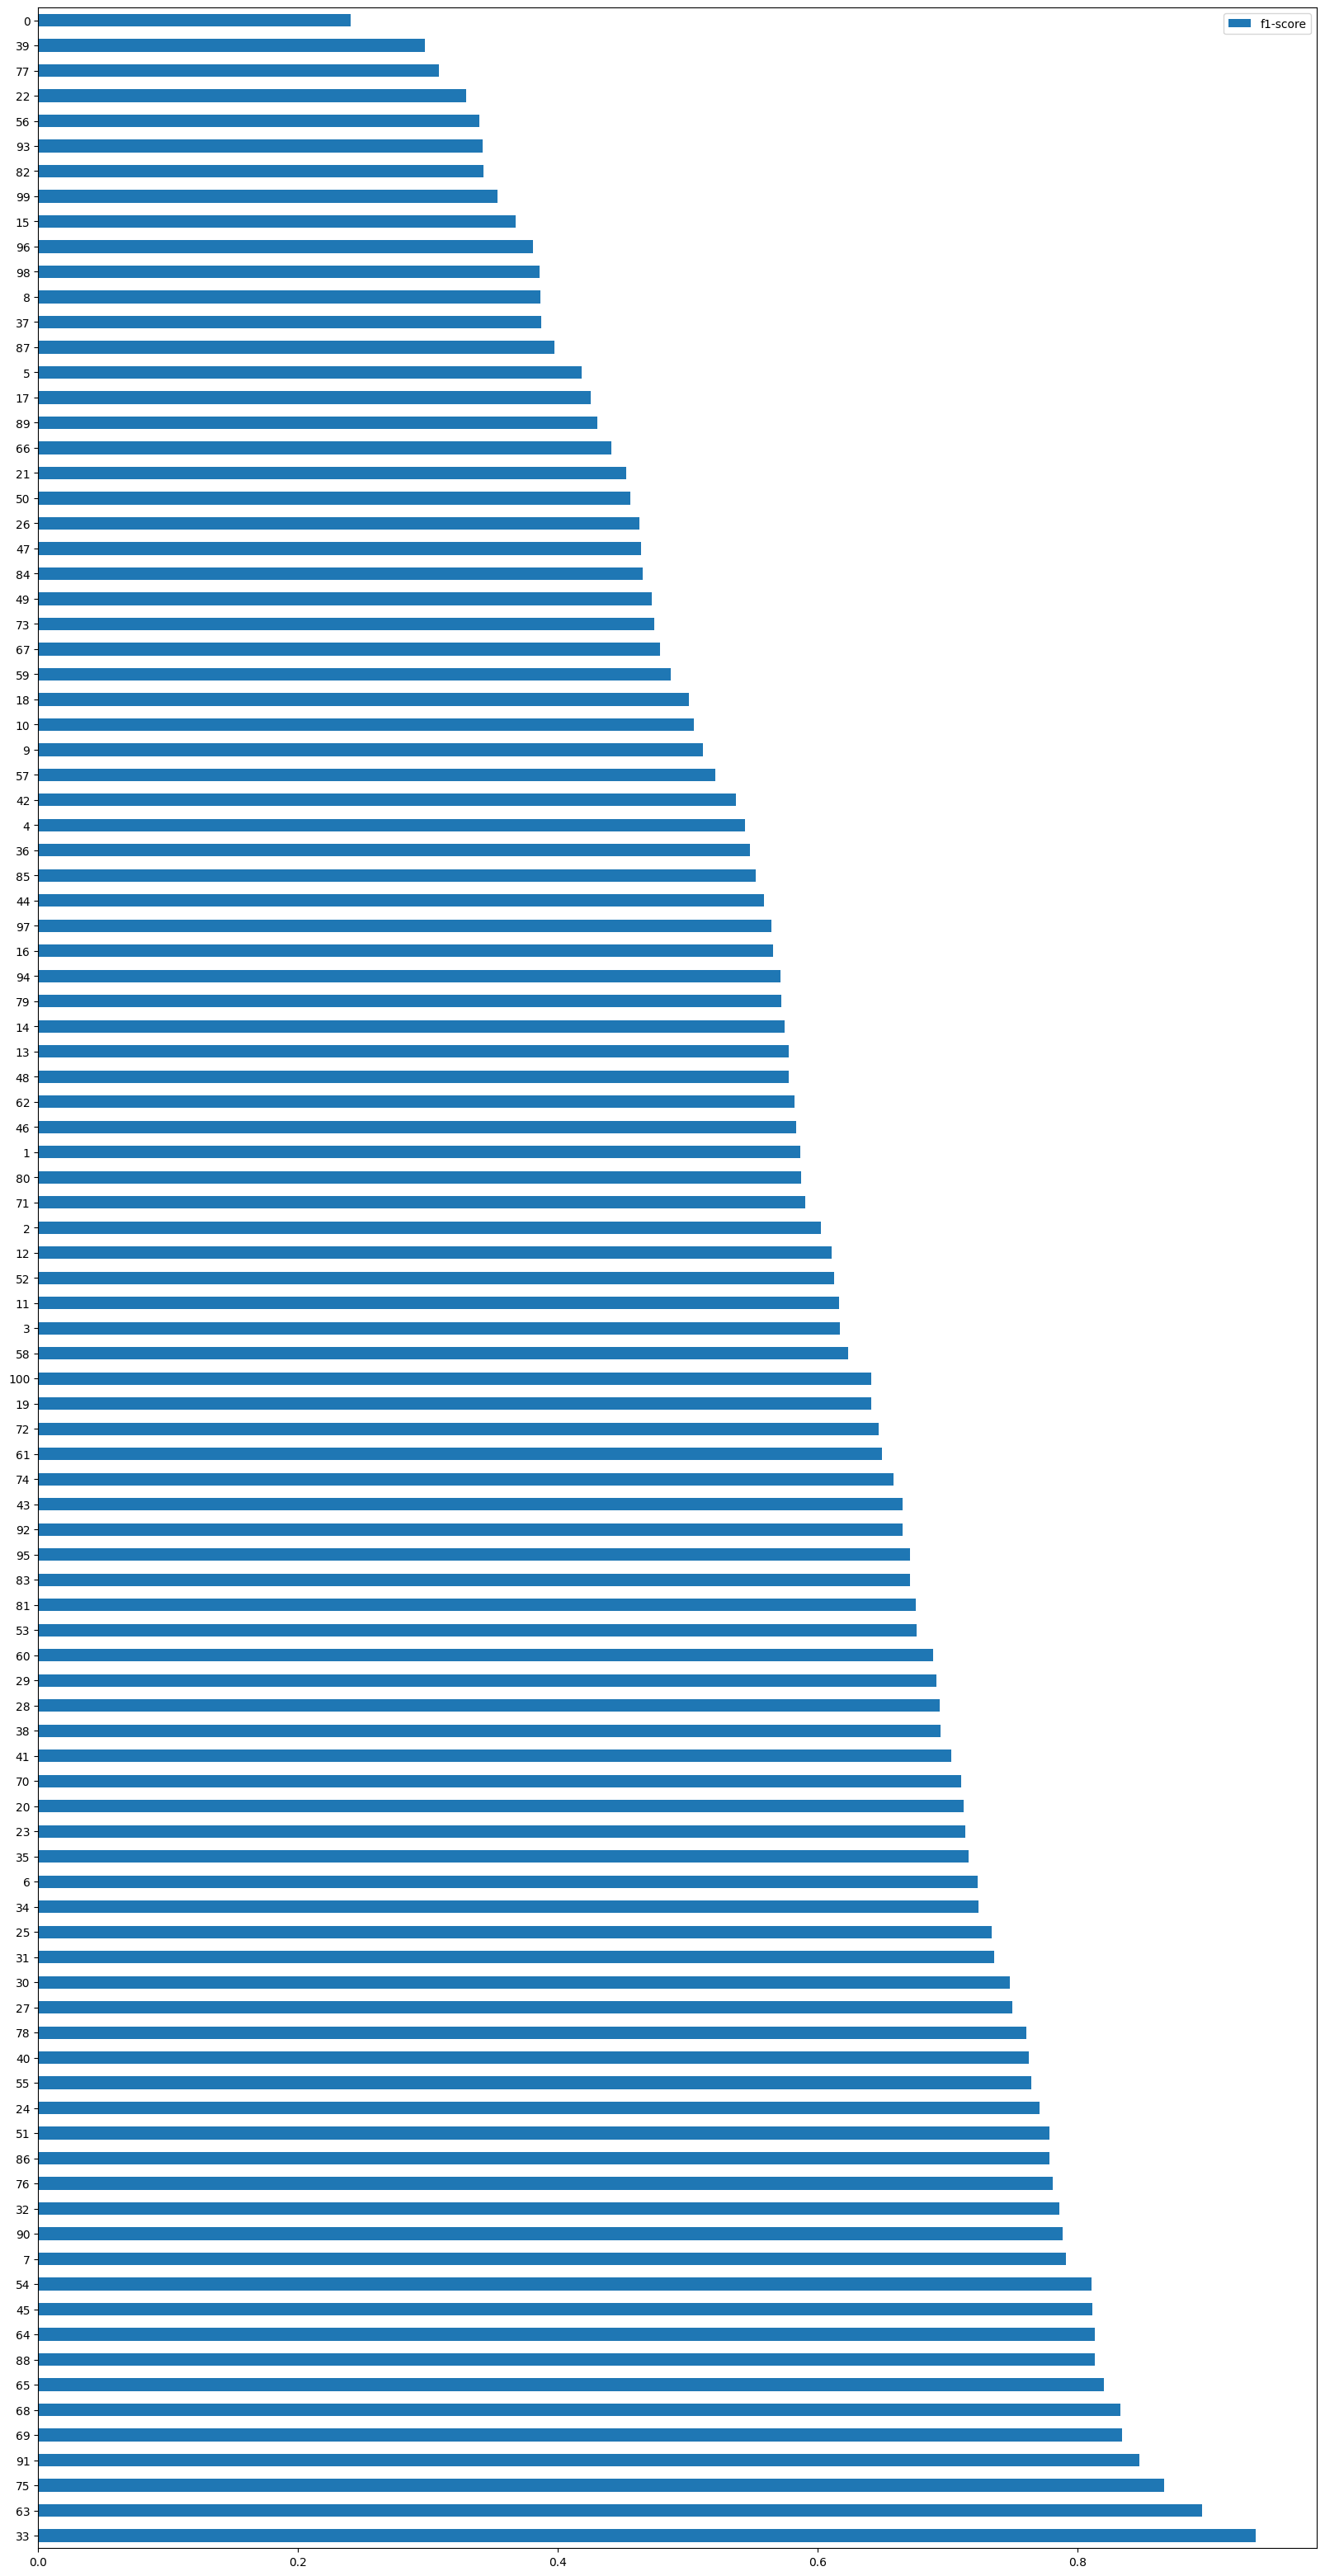

In [ ]:
f1_scores.plot(kind="barh", figsize=(20,40)) #plot f1 scores

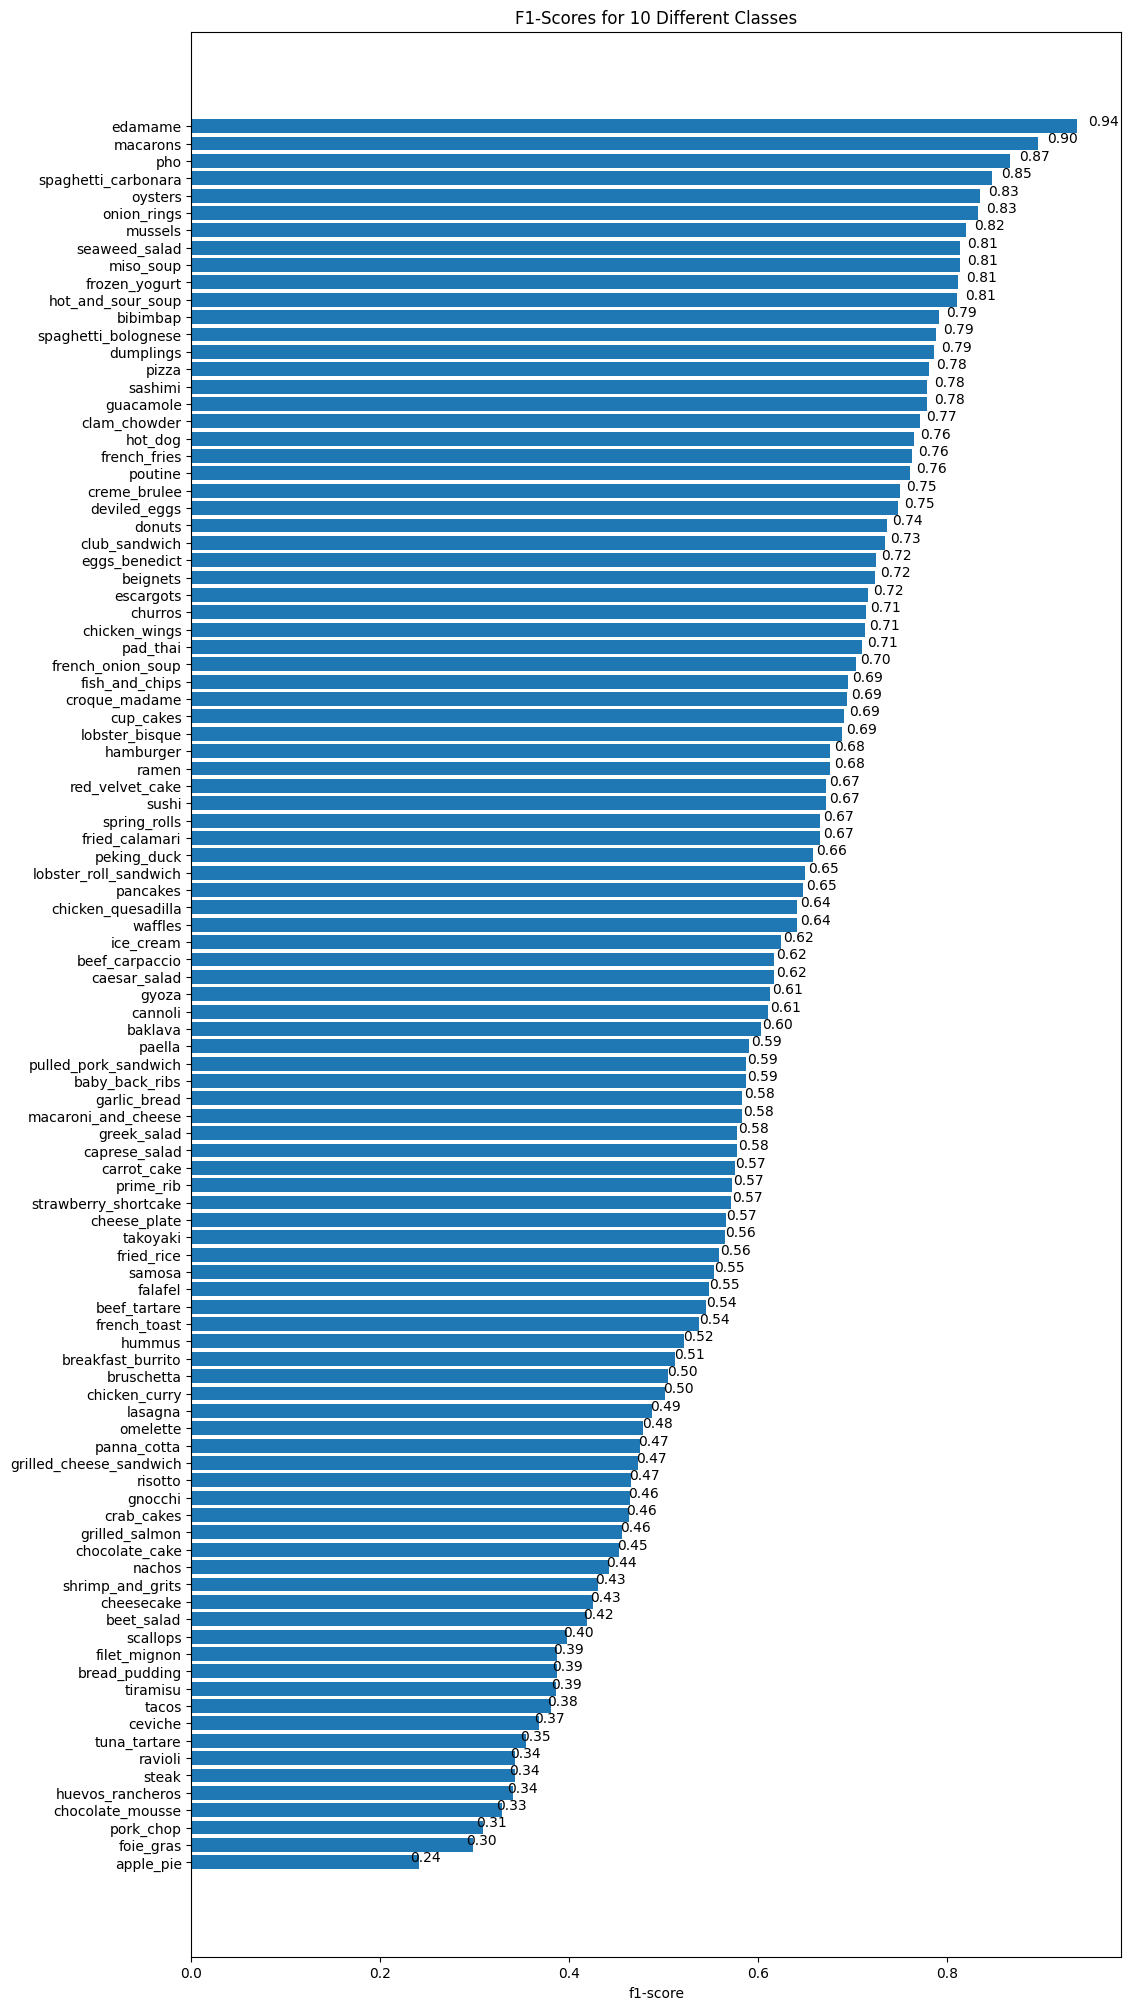

In [ ]:
#use autolabel function to add the f1 score on the end of each bar
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12, 25))
scores = ax.barh(range(len(f1_scores)), f1_scores["f1-score"].values)
ax.set_yticks(range(len(f1_scores)))
ax.set_yticklabels(list(f1_scores["class_names"]))
ax.set_xlabel("f1-score")
ax.set_title("F1-Scores for 10 Different Classes")
ax.invert_yaxis(); # reverse the order

def autolabel(rects): # Modified version of: https://matplotlib.org/examples/api/barchart_demo.html
  """
  Attach a text label above each bar displaying its height (it's value).
  """
  for rect in rects:
    width = rect.get_width()
    ax.text(1.03*width, rect.get_y() + rect.get_height()/1.5,
            f"{width:.2f}",
            ha='center', va='bottom')

autolabel(scores)


## Visualizing predictions on test images

In [ ]:
# Create a function to load and prepare images
def load_and_prep_image(filename, img_shape=224, scale=True):
    # Read in the image
  img=tf.io.read_file(filename)

  # Decode image into tensor
  img=tf.io.decode_image(img, channels=3)

  # Resize the image
  img=tf.image.resize(img, [img_shape, img_shape])

  if scale:
    return img/255.

  else:
    return img # don't need to rescale images for EfficientNet models in TensorFlow


1/1 [==============================] - 0s 35ms/step


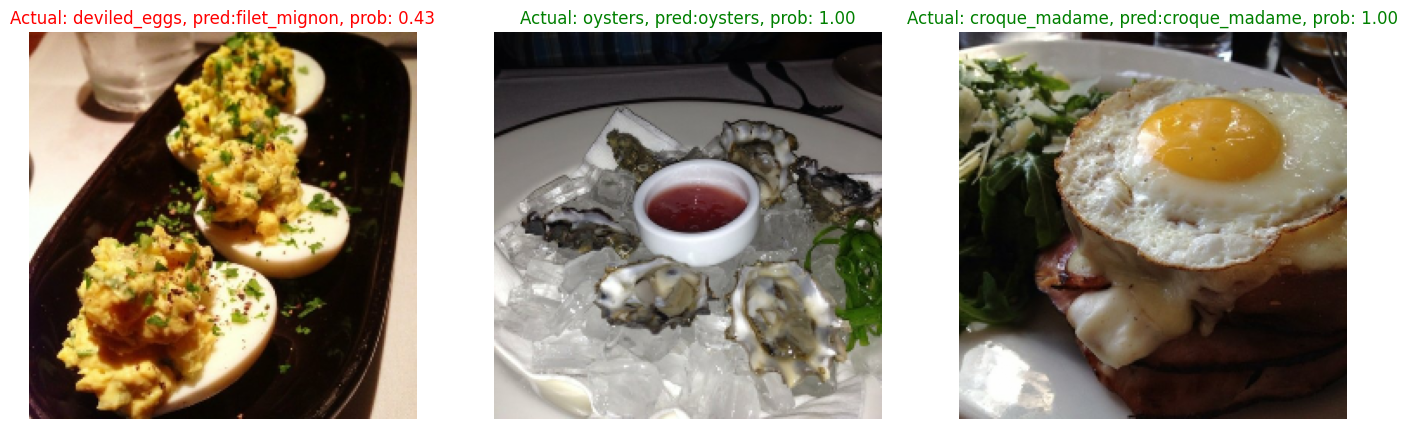

In [ ]:
import os
import random

# Make preds on a series of random images
plt.figure(figsize=(17, 10))

for i in range(3):
  # Choose random image(s) from random class(es)
  class_name=random.choice(class_names)
  filename=random.choice(os.listdir(test_dir+"/"+ class_name))
  filepath= test_dir+class_name+"/"+ filename

  # Load the image and make predictions
  img=load_and_prep_image(filepath, scale=False)
  pred_prob=model.predict(tf.expand_dims(img, axis=0))
  pred_class=class_names[pred_prob.argmax()]

  # Plot the images
  plt.subplot(1, 3, i+1)
  plt.imshow(img/255)

  if class_name==pred_class:
    title_color="g"
  else:
    title_color="r"

  plt.title(f"Actual: {class_name}, pred:{pred_class}, prob: {pred_prob.max():.2f}", c=title_color)
  plt.axis(False)





##Finding the most wrong predictions

In [ ]:
# 1. Get all of the image file paths in the test dataset
filepaths=[]

for filepath in test_data.list_files("/content/101_food_classes_10_percent/test/*/*.jpg", shuffle=False):
  filepaths.append(filepath.numpy())
filepaths[:10]



[b'/content/101_food_classes_10_percent/test/apple_pie/1011328.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/101251.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1034399.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/103801.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1038694.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1047447.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1068632.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/110043.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1106961.jpg',
 b'/content/101_food_classes_10_percent/test/apple_pie/1113017.jpg']

In [ ]:
# 2. Create a DataFrame of different parameters for each of our test images
pred_df=pd.DataFrame({"img_path": filepaths,
                      "y_true": y_labels,
                      "y_pred": pred_classes,
                     "pred_conf": pred_probs.max(axis=1),
                      "y_true_classname": [class_names[i] for i in y_labels],
                      "y_pred_classname": [class_names[i] for i in pred_classes]})

In [ ]:
pred_df

img_path  y_true  y_pred  \
0      b'/content/101_food_classes_10_percent/test/ap...       0      52   
1      b'/content/101_food_classes_10_percent/test/ap...       0       0   
2      b'/content/101_food_classes_10_percent/test/ap...       0       0   
3      b'/content/101_food_classes_10_percent/test/ap...       0      80   
4      b'/content/101_food_classes_10_percent/test/ap...       0      79   
...                                                  ...     ...     ...   
25245  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25246  b'/content/101_food_classes_10_percent/test/wa...     100      16   
25247  b'/content/101_food_classes_10_percent/test/wa...     100     100   
25248  b'/content/101_food_classes_10_percent/test/wa...     100      94   
25249  b'/content/101_food_classes_10_percent/test/wa...     100     100   

       pred_conf y_true_classname      y_pred_classname  
0       0.847418        apple_pie                 gyoza  
1       0.964017        apple_pie             apple_pie  
2       0.959259        apple_pie             apple_pie  
3       0.658607        apple_pie  pulled_pork_sandwich  
4       0.367901        apple_pie             prime_rib  
...          ...              ...                   ...  
25245   0.972823          waffles               waffles  
25246   0.878028          waffles          cheese_plate  
25247   0.537899          waffles               waffles  
25248   0.501950          waffles  strawberry_shortcake  
25249   0.690629          waffles               waffles  

[25250 rows x 6 columns]

In [ ]:
# 3. Find out in our DataFrame which predictions are wrong
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

img_path  y_true  y_pred  \
0  b'/content/101_food_classes_10_percent/test/ap...       0      52   
1  b'/content/101_food_classes_10_percent/test/ap...       0       0   
2  b'/content/101_food_classes_10_percent/test/ap...       0       0   
3  b'/content/101_food_classes_10_percent/test/ap...       0      80   
4  b'/content/101_food_classes_10_percent/test/ap...       0      79   

   pred_conf y_true_classname      y_pred_classname  pred_correct  
0   0.847418        apple_pie                 gyoza         False  
1   0.964017        apple_pie             apple_pie          True  
2   0.959259        apple_pie             apple_pie          True  
3   0.658607        apple_pie  pulled_pork_sandwich         False  
4   0.367901        apple_pie             prime_rib         False

In [ ]:
# 4. Sort our DataFrame to have most wrong predictions at the top
top_100_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)[:100]
top_100_wrong.head(20)

img_path  y_true  y_pred  \
21810  b'/content/101_food_classes_10_percent/test/sc...      87      29   
231    b'/content/101_food_classes_10_percent/test/ap...       0     100   
15359  b'/content/101_food_classes_10_percent/test/lo...      61      53   
23539  b'/content/101_food_classes_10_percent/test/st...      94      83   
21400  b'/content/101_food_classes_10_percent/test/sa...      85      92   
24540  b'/content/101_food_classes_10_percent/test/ti...      98      83   
2511   b'/content/101_food_classes_10_percent/test/br...      10      61   
5574   b'/content/101_food_classes_10_percent/test/ch...      22      21   
17855  b'/content/101_food_classes_10_percent/test/pa...      71      65   
23797  b'/content/101_food_classes_10_percent/test/su...      95      86   
18001  b'/content/101_food_classes_10_percent/test/pa...      72      67   
11642  b'/content/101_food_classes_10_percent/test/ga...      46      10   
10847  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23631  b'/content/101_food_classes_10_percent/test/st...      94      83   
1155   b'/content/101_food_classes_10_percent/test/be...       4       5   
10854  b'/content/101_food_classes_10_percent/test/fr...      43      68   
23904  b'/content/101_food_classes_10_percent/test/su...      95      86   
7316   b'/content/101_food_classes_10_percent/test/cu...      29      83   
13144  b'/content/101_food_classes_10_percent/test/gy...      52      92   
10880  b'/content/101_food_classes_10_percent/test/fr...      43      68   

       pred_conf       y_true_classname       y_pred_classname  pred_correct  
21810   0.999997               scallops              cup_cakes         False  
231     0.999995              apple_pie                waffles         False  
15359   0.999988  lobster_roll_sandwich              hamburger         False  
23539   0.999987   strawberry_shortcake        red_velvet_cake         False  
21400   0.999981                 samosa           spring_rolls         False  
24540   0.999947               tiramisu        red_velvet_cake         False  
2511    0.999945             bruschetta  lobster_roll_sandwich         False  
5574    0.999939       chocolate_mousse         chocolate_cake         False  
17855   0.999931                 paella                mussels         False  
23797   0.999904                  sushi                sashimi         False  
18001   0.999904               pancakes               omelette         False  
11642   0.999877           garlic_bread             bruschetta         False  
10847   0.999872         fried_calamari            onion_rings         False  
23631   0.999858   strawberry_shortcake        red_velvet_cake         False  
1155    0.999858           beef_tartare             beet_salad         False  
10854   0.999854         fried_calamari            onion_rings         False  
23904   0.999823                  sushi                sashimi         False  
7316    0.999816              cup_cakes        red_velvet_cake         False  
13144   0.999799                  gyoza           spring_rolls         False  
10880   0.999778         fried_calamari            onion_rings         False

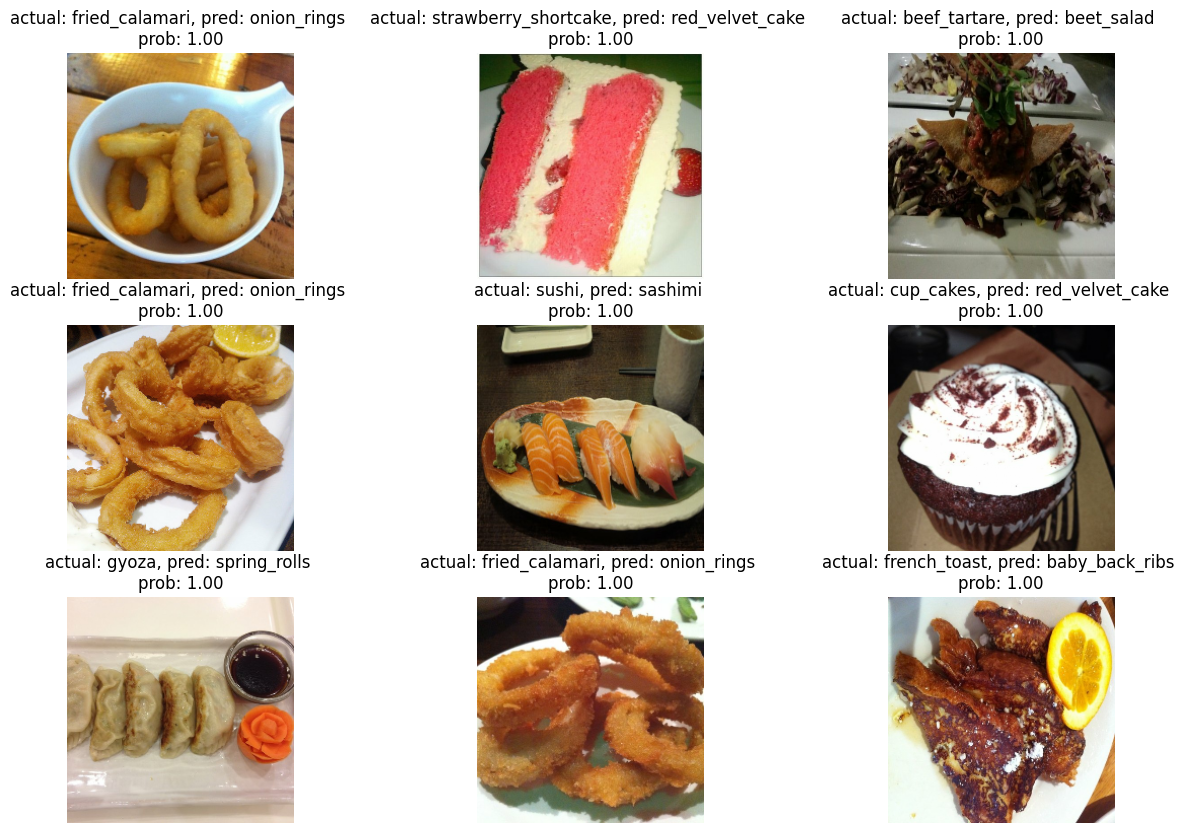

In [ ]:
# 5. Visualize the test data samples which have the wrong prediction but highest pred probability
images_to_view = 9
start_index = 12 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_100_wrong[start_index:start_index+images_to_view].itertuples()):
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)

## Test the model on custom images

In [ ]:
# Get custom images
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Pizza_in_Indonesian_Restaurant.jpg/640px-Pizza_in_Indonesian_Restaurant.jpg

--2023-12-27 18:07:46--  https://upload.wikimedia.org/wikipedia/commons/thumb/b/b6/Pizza_in_Indonesian_Restaurant.jpg/640px-Pizza_in_Indonesian_Restaurant.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78584 (77K) [image/jpeg]
Saving to: ‘640px-Pizza_in_Indonesian_Restaurant.jpg’

640px-Pizza_in_Indo 100%[===================>]  76.74K  --.-KB/s    in 0.05s   

2023-12-27 18:07:46 (1.43 MB/s) - ‘640px-Pizza_in_Indonesian_Restaurant.jpg’ saved [78584/78584]



In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Modern_fish_and_chips_%288368723726%29.jpg/640px-Modern_fish_and_chips_%288368723726%29.jpg

!wget https://upload.wikimedia.org/wikipedia/commons/thumb/3/33/Macaroni_Cheese_with_Prawns_%2833515714955%29.jpg/640px-Macaroni_Cheese_with_Prawns_%2833515714955%29.jpg
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/8/8a/Tacos_from_Tacos_Padre.jpg/640px-Tacos_from_Tacos_Padre.jpg

In [ ]:
!wget https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Egypt_falafel.jpg/640px-Egypt_falafel.jpg

--2023-12-27 18:45:12--  https://upload.wikimedia.org/wikipedia/commons/thumb/1/19/Egypt_falafel.jpg/640px-Egypt_falafel.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 78124 (76K) [image/jpeg]
Saving to: ‘640px-Egypt_falafel.jpg’

640px-Egypt_falafel 100%[===================>]  76.29K  --.-KB/s    in 0.05s   

2023-12-27 18:45:12 (1.59 MB/s) - ‘640px-Egypt_falafel.jpg’ saved [78124/78124]



In [ ]:
# Get the custom food images filepaths
custom_food_images=["custom_food_images/"+img_path for img_path in os.listdir("custom_food_images")]
custom_food_images

['custom_food_images/640px-Egypt_falafel.jpg',
 'custom_food_images/640px-Pizza_in_Indonesian_Restaurant.jpg',
 'custom_food_images/640px-Tacos_from_Tacos_Padre.jpg',
 'custom_food_images/640px-Macaroni_Cheese_with_Prawns_(33515714955).jpg',
 'custom_food_images/640px-Modern_fish_and_chips_(8368723726).jpg']

1/1 [==============================] - 0s 31ms/step


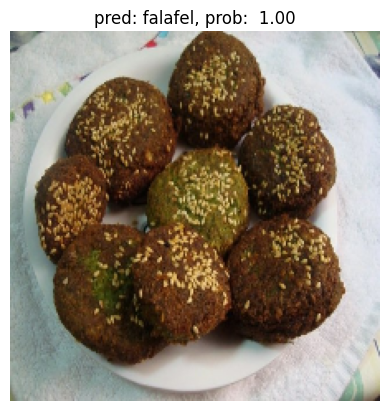

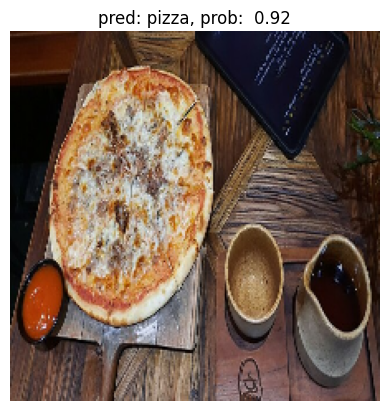

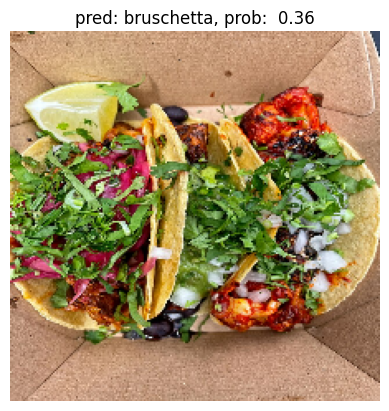

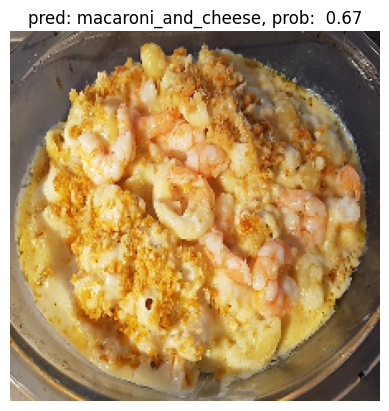

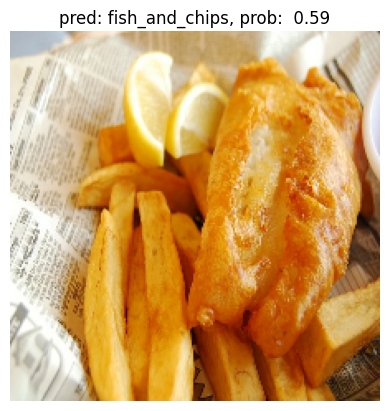

In [ ]:
# Make predictions on and plot custom food images
for img in custom_food_images:
  img=load_and_prep_image(img, scale=False) # don't need to scale for our EfficientNetB0 model
  pred_prob= model.predict(tf.expand_dims(img, axis=0)) # make prediction on image with shape [1, 224, 224, 3]
  pred_class= class_names[pred_prob.argmax()]

  plt.figure()
  plt.imshow(img/255.)
  plt.title(f"pred: {pred_class}, prob: {pred_prob.max(): .2f}")
  plt.axis(False)